# Enron Fraud Detection

This is the final project of udacity class "[Intro to Machine Learning](https://classroom.udacity.com/courses/ud120)". The goal is building an algorithm to identify Enron employees who may have committed fraud based on the public Enron financial and email dataset.

This notebook relies on code provided by the class, which is available [here](https://github.com/udacity/ud120-projects). Put this notebook in the final_project folder and it should work.

In [1]:
import pickle
import sys
sys.path.append("../tools/")

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
### Also convert to dataframe for easy manipulation.
import pandas as pd
import numpy as np
df = pd.DataFrame.from_dict(data_dict, orient='index')
for column in df.columns:
    if column == 'email_address':
        continue
    # Convert NaN to 0.
    df[column] = df[column].apply(lambda x: 0 if x == 'NaN' else float(x))

## Task 1: Select what features you'll use

I choose to select all the features available at this step.

In [185]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi',
                 'salary', 'deferral_payments', 'total_payments',
                 'exercised_stock_options', 'bonus', 'restricted_stock',
                 'total_stock_value', 'expenses', 'loan_advances',
                 'director_fees', 'deferred_income', 'long_term_incentive',
                 'to_messages', 'shared_receipt_with_poi', 'from_messages',
                 'from_this_person_to_poi', 'from_poi_to_this_person']

## Task 2: Remove outliers

Use histogram to identify outliers. Start with salary.

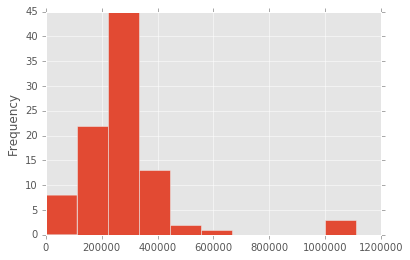

In [294]:
import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

df['salary'].plot.hist(by='salary')

There seems to be an outlier, A 25 million salary seems really high. Let's find it.

In [262]:
df['salary'].idxmax()

'TOTAL'

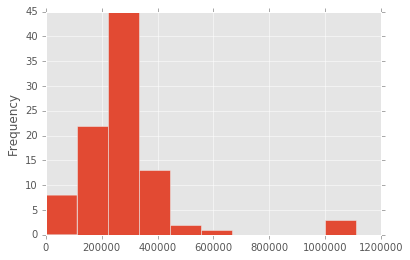

In [263]:
# Drop 'TOTAL' and replot.
df=df.drop('TOTAL')
df['salary'].plot.hist()

In [264]:
# Let's check some high salaries.
df[df['salary'] > 800000]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
FREVERT MARK A,1060932.0,3275.0,6426990.0,17252530.0,10433518.0,2000000.0,4188667.0,2979.0,NaN,14622185.0,...,2000000.0,21.0,7427621.0,6.0,0.0,NaN,-3367011.0,1617011.0,mark.frevert@enron.com,242.0
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,NaN,49110078.0,...,81525000.0,36.0,10359729.0,16.0,1.0,NaN,-300000.0,3600000.0,kenneth.lay@enron.com,123.0
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,19250000.0,5600000.0,6843672.0,2042.0,NaN,26093672.0,...,NaN,108.0,22122.0,30.0,1.0,NaN,NaN,1920000.0,jeff.skilling@enron.com,88.0


The results seems reasonable: Lay Kenneth is the CEO of Enron, Frevert Mark is the CEO of Enron wholesale services, Skilling Jeffrey is former CEO of Enron. Let's continue to check other compensation data. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120dc0b10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121751550>]], dtype=object)

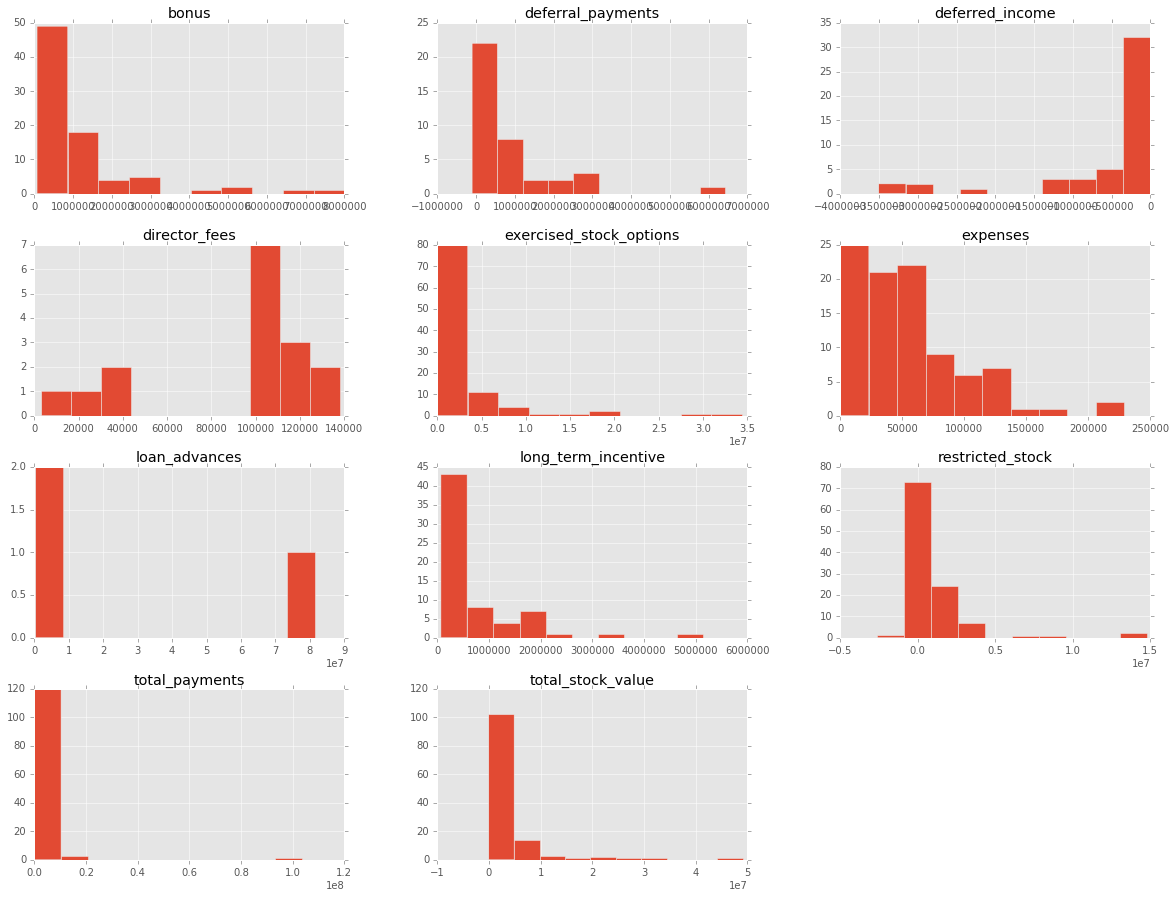

In [265]:
df[['deferral_payments', 'total_payments',
      'exercised_stock_options', 'bonus', 'restricted_stock',
      'total_stock_value', 'expenses', 'loan_advances',
      'director_fees', 'deferred_income', 'long_term_incentive']].hist(figsize=(20, 15))

In [266]:
# Let's double check data with high total payments

df[df['total_payments'] > 80000000]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,NaN,49110078.0,...,81525000.0,36.0,10359729.0,16.0,1.0,NaN,-300000.0,3600000.0,kenneth.lay@enron.com,123.0


CEO Kenneth Lay got high payment seems reasonable. Continue with email data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111282290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c6a23d0>]], dtype=object)

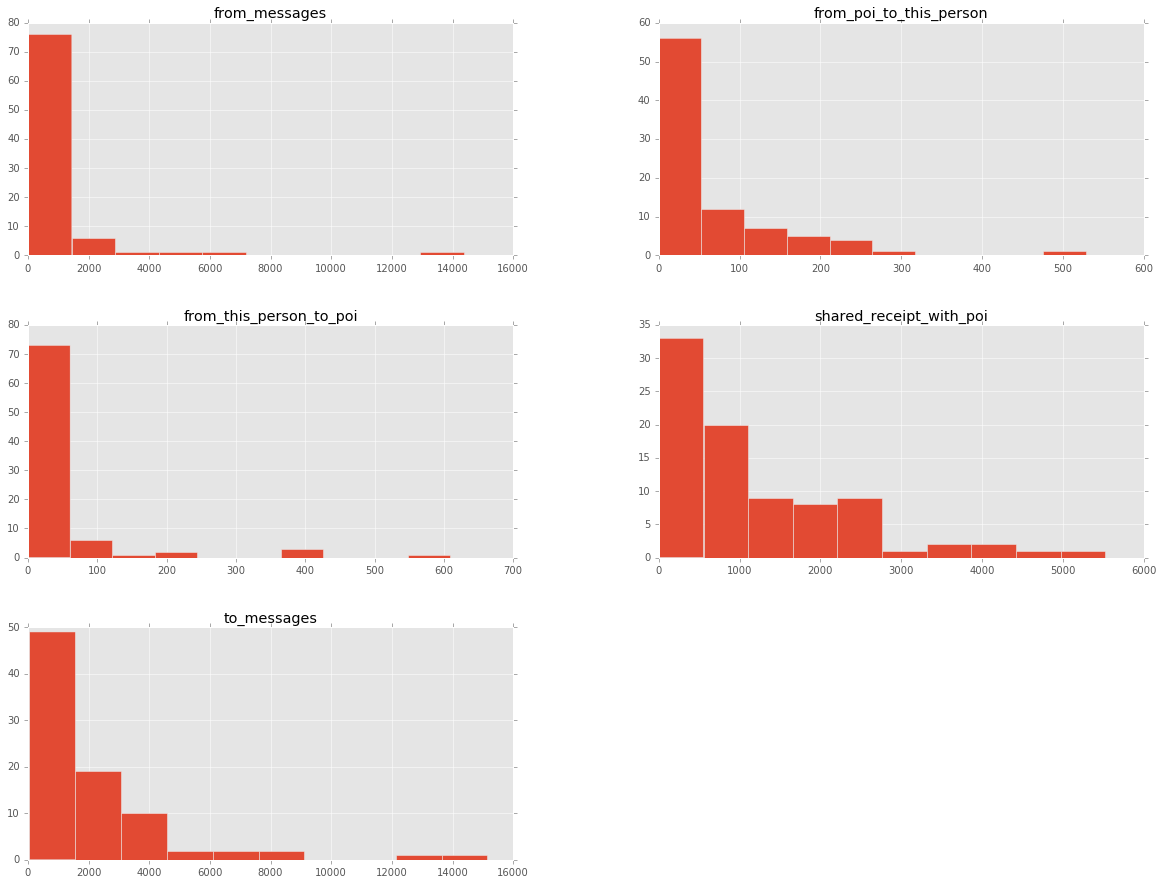

In [267]:
df[['to_messages', 'shared_receipt_with_poi', 'from_messages',
      'from_this_person_to_poi', 'from_poi_to_this_person']].hist(figsize=(20, 15))

Now there seems to be no outlier. Continue with feature selection.

## Task 3: Create new feature(s)

In [270]:
# My first thought is to build TFIDF matrix. However, it turns out the email data is very incomplete. 
# We only have 19 people's email out of the 145 people given.
#
# There are two sets of email data provided:
# 
# 1. Email folder. For each person, if we have their email, there will be a folder named 
#    LastName-FirstLetterOfFirstName. For example:
#    maildir/
#      allen-p
#        inbox/
#        send/
#
# 2. Email index file: For each person, we might have a file named 


def name_to_folder_name(last_first_middle):
    parts = last_first_middle.split(' ')
    if len(parts) < 2:
        return ''
    return '-'.join([parts[0].lower(), parts[1][0].lower()])

def name_to_file_name(last_first_middle):
    parts = last_first_middle.split(' ')
    if len(parts) < 2:
        return ''
    return parts[1].lower() + '.' + parts[0].lower() + '@enron.com.txt'


name_count = 0
folder_count = 0
file_count = 0
for name in df.index.values:
    if os.path.isdir('../maildir/' + name_to_folder_name(name)):
        folder_count = folder_count + 1
    file_name_suffix = name_to_file_name(name)
    if os.path.exists('emails_by_address/' + 'from_' + file_name_suffix) or os.path.exists('emails_by_address/' + 'to_' + file_name_suffix):
        file_count = file_count + 1
    name_count = name_count + 1
    
print folder_count, file_count, name_count

19 55 145


In [271]:
## My second thought is to scale the number of poi related emails by total number of emails.

df['ratio_of_poi_related_email'] = (df['from_poi_to_this_person'] + df['from_this_person_to_poi'])/(df['to_messages'] + df['from_messages'])

# Also add to feature_list.
if 'ratio_of_poi_related_email' not in features_list:
    features_list.append('ratio_of_poi_related_email')

## Task 4: Try a varity of classifiers

In [272]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

import tester

### Store to my_dataset for easy export below.
my_dataset = df.fillna(0).to_dict(orient='index')

In [9]:
from sklearn import naive_bayes
clf = naive_bayes.GaussianNB()
tester.test_classifier(clf, my_dataset, features_list)

GaussianNB()
	Accuracy: 0.31167	Precision: 0.14175	Recall: 0.82350	F1: 0.24187	F2: 0.41975
	Total predictions: 15000	True positives: 1647	False positives: 9972	False negatives:  353	True negatives: 3028



In [274]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
tester.test_classifier(clf, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.80580	Precision: 0.28021	Recall: 0.29100	F1: 0.28550	F2: 0.28878
	Total predictions: 15000	True positives:  582	False positives: 1495	False negatives: 1418	True negatives: 11505



In [275]:
from sklearn import ensemble
clf = ensemble.RandomForestClassifier()
tester.test_classifier(clf, my_dataset, features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.85793	Precision: 0.39065	Recall: 0.11700	F1: 0.18007	F2: 0.13606
	Total predictions: 15000	True positives:  234	False positives:  365	False negatives: 1766	True negatives: 12635



In [276]:
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(criterion='entropy')
tester.test_classifier(clf, my_dataset, features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.85973	Precision: 0.40114	Recall: 0.10550	F1: 0.16706	F2: 0.12374
	Total predictions: 15000	True positives:  211	False positives:  315	False negatives: 1789	True negatives: 12685



In [279]:
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(min_samples_split=20)
tester.test_classifier(clf, my_dataset, features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.86200	Precision: 0.42944	Recall: 0.10650	F1: 0.17067	F2: 0.12535
	Total predictions: 15000	True positives:  213	False positives:  283	False negatives: 1787	True negatives: 12717



In [289]:
from sklearn.pipeline import Pipeline
from sklearn import ensemble
from sklearn.decomposition import RandomizedPCA
estimators = [('reduce_dim', RandomizedPCA(n_components=5)), ('rf', ensemble.RandomForestClassifier(min_samples_split=20))]
clf = Pipeline(estimators)
tester.test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('reduce_dim', RandomizedPCA(copy=True, iterated_power=3, n_components=5, random_state=None,
       whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.86060	Precision: 0.43396	Recall: 0.14950	F1: 0.22239	F2: 0.17206
	Total predictions: 15000	True positives:  299	False positives:  390	False negatives: 1701	True negatives: 12610



In [290]:
from sklearn.pipeline import Pipeline
from sklearn import ensemble
from sklearn.decomposition import RandomizedPCA
estimators = [('reduce_dim', RandomizedPCA(n_components=5)), ('rf', ensemble.AdaBoostClassifier())]
clf = Pipeline(estimators)
tester.test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('reduce_dim', RandomizedPCA(copy=True, iterated_power=3, n_components=5, random_state=None,
       whiten=False)), ('rf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
	Accuracy: 0.82400	Precision: 0.28495	Recall: 0.21200	F1: 0.24312	F2: 0.22344
	Total predictions: 15000	True positives:  424	False positives: 1064	False negatives: 1576	True negatives: 11936



In [293]:
from sklearn import ensemble
clf = ensemble.AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                  learning_rate=2.0, n_estimators=50, random_state=None)
tester.test_classifier(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=2.0, n_estimators=50, random_state=None)
	Accuracy: 0.77753	Precision: 0.24953	Recall: 0.33300	F1: 0.28529	F2: 0.31212
	Total predictions: 15000	True positives:  666	False positives: 2003	False negatives: 1334	True negatives: 10997



## Task 5: Tune classifier

In [295]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

from sklearn import ensemble
clf = ensemble.AdaBoostClassifier(n_estimators=50)
tester.test_classifier(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.83933	Precision: 0.37025	Recall: 0.29250	F1: 0.32682	F2: 0.30532
	Total predictions: 15000	True positives:  585	False positives:  995	False negatives: 1415	True negatives: 12005



In [296]:
from sklearn import ensemble
clf = ensemble.AdaBoostClassifier(n_estimators=100)
tester.test_classifier(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)
	Accuracy: 0.84233	Precision: 0.38172	Recall: 0.29450	F1: 0.33249	F2: 0.30860
	Total predictions: 15000	True positives:  589	False positives:  954	False negatives: 1411	True negatives: 12046



In [297]:
from sklearn import ensemble
clf = ensemble.AdaBoostClassifier(n_estimators=200)
tester.test_classifier(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)
	Accuracy: 0.84220	Precision: 0.37840	Recall: 0.28550	F1: 0.32545	F2: 0.30024
	Total predictions: 15000	True positives:  571	False positives:  938	False negatives: 1429	True negatives: 12062



In [299]:
from sklearn import ensemble
clf = ensemble.AdaBoostClassifier(n_estimators=75)
tester.test_classifier(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=75, random_state=None)
	Accuracy: 0.84367	Precision: 0.38949	Recall: 0.30400	F1: 0.34148	F2: 0.31796
	Total predictions: 15000	True positives:  608	False positives:  953	False negatives: 1392	True negatives: 12047



__So n_estimators = 75 will give us a result with precision 0.39 and recall 0.30.__

## Task 6: Dump classifier, dataset and feature_list

In [301]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

from tester import dump_classifier_and_data

dump_classifier_and_data(clf, my_dataset, features_list)